# TP: Simulation of a Nanosatellite Swarm

This session takes place in the context of **dynamic distributed networks**, with a focus on **nanosatellite swarms**. It is inspired by real use cases such as the NOIRE project (Nano-satellite Observatory for Interferometric Radio Exploration), which aims to deploy a distributed radio interferometer in lunar orbit.

---

## Objectives

The goal of this TP is to:

- Dynamically model a swarm of 100 nanosatellites as a time-evolving graph.
- Study the **connectivity**, **availability**, and **resilience** of the network.
- Apply **equitable division algorithms** (clustering/Partioning) to reduce routing overhead and improve failure tolerance.
- Compare divsion algorithms using various **network metrics** (degree, density, redundancy, criticality, etc.).

---

## Simulated Scenario

- 100 nanosatellites in lunar orbit
- Satellite coordinates (x, y, z) available at every time step (every **10 seconds**) in Traces.csv
- A communication link exists if the inter-satellite distance is < **30 km**

---

## TP Structure

| Step | Description |
|------|-------------|
| 1 | Read satellite position data |
| 2️ | Build the dynamic graph Gt at a given time |
| 3️ | Analyze connectivity and node neighborhood |
| 4️ | Apply division algorithms (RND, MIRW, FFD) and clustering(kMeans) |
| 5️ | Compute metrics: AD, GD, ACC, Diameter, RMSE, etc. |
| 6️ | Simulate failures: random or removal of critical nodes |
| 7️ | Analyze resilience before / after failure |

---

> All metrics are defined in `metrics.py`, and divsion/clustering algorithms are implemented in `swarm_sim.py`.


In [2]:
import pandas as pd
from swarm_sim import *
from metrics import *
import random 
import nbimporter
from metrics import path_disparity, path_redundancy, routing_cost, flow_robustness, network_efficiency, critical_nodes
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from IPython.display import HTML
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Circle
import matplotlib.animation as animation
import numpy as np

## 1. Data Loading 

In this part, we load the satellite position traces from `Traces.csv`

In [3]:
df = pd.read_csv("Traces.csv", header=None)  

# Create time colomns 
time_cols = [str(i+1) for i in range(10000)]
df.columns = time_cols

#generate rows (satellite coordinates)
coord_names = []
for i in range(1, 101):  # 100 nanosatellites 
    coord_names.append(f"satx{i}")
    coord_names.append(f"saty{i}")
    coord_names.append(f"satz{i}")
df["coords"] = coord_names
df = df.set_index("coords")
dft = df.transpose()  # row = instant of time 

## 2. Convert to Swarm : Dynamic Graph Construction

At each time step `t`, the swarm is represented as a dynamic graph `Gt`.

We will:
- Build the connectivity graph based on the satellite coordinates loaded and connection range.
- Observe how the topology evolves over time.


In [4]:
def create_swarm_snapshot(Dft: pd.DataFrame, t: int, connection_range=30000) -> tuple:
    """
    Create a Swarm and its NetworkX graph from coordinates at t.

    Args:
        Dft (pd.DataFrame): DataFrame , raw = instant
        t (int): index temporal (0 ≤ t < nb_snapshots)
        connection_range (float):communication range m

    Returns:
        swarm (Swarm): swarm object (see the class Swarm in swarm_sim.py)
        G (nx.Graph):  NetworkX graph representing the network at t 
    """
    coords = dft.iloc[t]
    nodes = []
    
    # Créer les objets Node
    for i in satellites_actifs:
        x = coords[f'satx{i}']
        y = coords[f'saty{i}']
        z = coords[f'satz{i}']
        nodes.append(Node(id=i, x=x, y=y, z=z))

    swarm = Swarm(connection_range=connection_range, nodes=nodes)

    # Créer un graphe nx
    G = nx.Graph()
    for node in nodes:
        G.add_node(node.id)

    # Ajouter les arêtes 
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)): 
            dist = nodes[i].compute_dist(nodes[j])
            if dist <= connection_range:
                G.add_edge(nodes[i].id, nodes[j].id)

    return swarm, G


## 3. Automatic Scenario Generation

You can modify the number of nodes, duration and communication range to explore different swarm configurations.

Use the generated scenario to evaluate how initial conditions impact the resulting graph.


## Swarm visualization

### 2D visualization

In [5]:
def draw_swarm_graph_2D(G, nodes, group_dict=None, title="Swarm Graph 2D"):
    """
    Affiche le graphe G en 2D selon les coordonnées réelles (x, y) des nœuds.

    Args:
        G (nx.Graph): Graphe NetworkX (arêtes à dessiner)
        nodes (list of Node): objets contenant id, x, y (projection plane)
        group_dict (dict): {node_id: group_id} pour afficher les clusters
        title (str): Titre du graphe
    """
    pos = {node.id: (node.x, node.y) for node in nodes}

    plt.figure(figsize=(4, 4))

    if group_dict:
        # Grouper les noeuds par cluster
        groups = {}
        for node_id, group_id in group_dict.items():
            groups.setdefault(group_id, []).append(node_id)

        cmap = matplotlib.colormaps.get_cmap('tab10')  # palette colorée

        for i, (group_id, nodelist) in enumerate(groups.items()):
            nx.draw_networkx_nodes(
                G, pos,
                nodelist=nodelist,
                node_color=[cmap(i % cmap.N)],
                label=f"Groupe {group_id}",
                node_size=300
            )
    else:
        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=30)

    # Dessiner les arêtes
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

    # Titre et axes
    plt.title(title)
    plt.xlabel("X (km)")
    plt.ylabel("Y (km)")
    plt.axis("equal")
    if group_dict:
        plt.legend()
    plt.grid(True)
    plt.show()


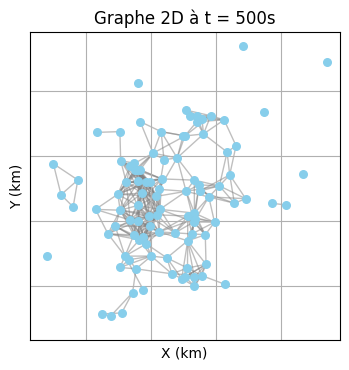

In [6]:
t= 500
connection_range = 30000
nanosat_count = 100
# Liste des satellites encore actifs
satellites_actifs = set(range(1, nanosat_count + 1))
swarm, G = create_swarm_snapshot(dft, t, connection_range=30000)
draw_swarm_graph_2D(G, swarm.nodes, title=f"Graphe 2D à t = {t}s")


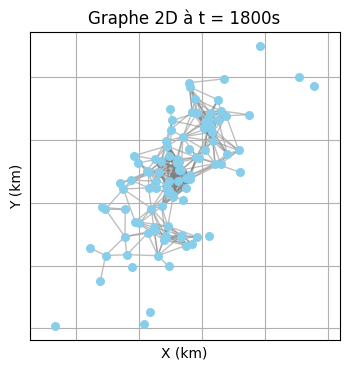

In [7]:
t= 1800
connection_range = 300000
nanosat_count = 100
# List of active satellites
satellites_actifs = set(range(1, nanosat_count + 1))
swarm, G = create_swarm_snapshot(dft, t, connection_range=30000)
draw_swarm_graph_2D(G, swarm.nodes, title=f"Graphe 2D à t = {t}s")


### 3D visualization

In [8]:

def draw_swarm_graph_3D(G, nodes, group_dict=None, title="Swarm Graph 3D"):
    """
    Affiche le graphe G en 3D à partir des coordonnées des satellites.

    Args:
        G (nx.Graph): Graphe NetworkX (avec edges)
        nodes (list of Node): objets contenant id, x, y, z
        group_dict (dict): {node_id: group_id} si clustering effectué
        title (str): Titre de la figure
    """
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Positions 3D des nœuds
    pos_dict = {node.id: (node.x, node.y, node.z) for node in nodes}

    # Affichage des arêtes
    for u, v in G.edges():
        x_vals = [pos_dict[u][0], pos_dict[v][0]]
        y_vals = [pos_dict[u][1], pos_dict[v][1]]
        z_vals = [pos_dict[u][2], pos_dict[v][2]]
        ax.plot(x_vals, y_vals, z_vals, c='gray', alpha=0.5)

    # Affichage des nœuds (groupés ou non)
    if group_dict:
        cmap = matplotlib.colormaps.get_cmap('tab10')
        groups = {}
        for node_id, group_id in group_dict.items():
            groups.setdefault(group_id, []).append(node_id)

        for i, (group_id, nodelist) in enumerate(groups.items()):
            xs = [pos_dict[n][0] for n in nodelist]
            ys = [pos_dict[n][1] for n in nodelist]
            zs = [pos_dict[n][2] for n in nodelist]
            ax.scatter(xs, ys, zs, color=cmap(i % cmap.N), s=60, label=f"Groupe {group_id}")
    else:
        xs = [pos_dict[n.id][0] for n in nodes]
        ys = [pos_dict[n.id][1] for n in nodes]
        zs = [pos_dict[n.id][2] for n in nodes]
        ax.scatter(xs, ys, zs, color='blue', s=60)

    ax.set_title(title)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    if group_dict:
        ax.legend()
    plt.tight_layout()
    plt.show()


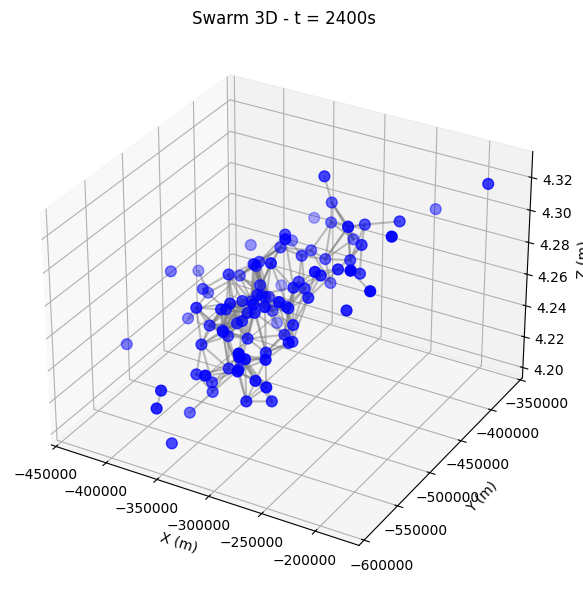

In [9]:
t = 2400
swarm, G = create_swarm_snapshot(dft, t, connection_range=30000)
draw_swarm_graph_3D(G, swarm.nodes, title=f"Swarm 3D - t = {t}s")


## 3D Animation of the Swarm: Lunar Orbit + Local Dynamics

This visualization shows the spatial and dynamic behavior of the swarm in real time.

It combines two synchronized perspectives:

- **Left panel**: the global orbital trajectory of the swarm around the Moon (geospatial context).
- **Right panel**: a dynamic local zoom on the swarm’s center of mass to observe internal structure and movement.

This animation helps you better understand the relative positioning and connectivity of nanosatellites at different time scales and distances.


In [10]:
def animate_swarm_dual(dft, time_range, connection_range=30000, interval=1000):
    """
    Synchronized dual animation:
    - Global view: orbit around the Moon
    - Local view: dynamic zoom on the swarm
    
    Returns:
        ani: animation.FuncAnimation
    """
  

    fig = plt.figure(figsize=(14, 7))
    ax1 = fig.add_subplot(121, projection='3d')  # global view
    ax2 = fig.add_subplot(122, projection='3d')  #local view

    moon_radius = 5e5  # visuel réduit
    zoom_delta = 3e5   # portée locale

    # Pre-treatment of data
    snapshots = []
    for t in tqdm(time_range, desc="Preparation of frames"):
        swarm, G = create_swarm_snapshot(dft, t, connection_range)
        snapshots.append((t, swarm, G))

    def draw_moon(ax):
        u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:20j]
        x = moon_radius * np.cos(u) * np.sin(v)
        y = moon_radius * np.sin(u) * np.sin(v)
        z = moon_radius * np.cos(v)
        ax.plot_surface(x, y, z, color='lightgray', alpha=0.4)

    def update(i):
        t, swarm, G = snapshots[i]
        pos = {node.id: (node.x, node.y, node.z) for node in swarm.nodes}

        # --- Vue globale ---
        ax1.cla()
        draw_moon(ax1)
        xg, yg, zg = zip(*pos.values())
        ax1.scatter(xg, yg, zg, color='blue', s=50)
        for u, v in G.edges():
            ax1.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]], [pos[u][2], pos[v][2]], c='gray', alpha=0.3)
        ax1.set_xlim(-2.5e6, 2.5e6)
        ax1.set_ylim(-2.5e6, 2.5e6)
        ax1.set_zlim(-2.5e6, 2.5e6)
        ax1.set_title(f"Global View – t = {t}s")

        # --- Vue locale ---
        ax2.cla()
        xc, yc, zc = np.mean(xg), np.mean(yg), np.mean(zg)
        ax2.set_xlim(xc - zoom_delta, xc + zoom_delta)
        ax2.set_ylim(yc - zoom_delta, yc + zoom_delta)
        ax2.set_zlim(zc - zoom_delta, zc + zoom_delta)
        ax2.scatter(xg, yg, zg, color='blue', s=50)
        for u, v in G.edges():
            ax2.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]], [pos[u][2], pos[v][2]], c='gray', alpha=0.3)
        ax2.set_title("local view (zoomed on the swarm)")

        # Labels
        for ax in [ax1, ax2]:
            ax.set_xlabel("X [m]")
            ax.set_ylabel("Y [m]")
            ax.set_zlabel("Z [m]")

        return []

    ani = animation.FuncAnimation(fig, update, frames=len(snapshots), interval=interval, blit=False)
    plt.close()
    return ani


In [42]:
time_range = range(0, 2000, 200)
ani = animate_swarm_dual(dft, time_range, connection_range=30000, interval=1500)

from IPython.display import HTML
HTML(ani.to_jshtml())


Preparation of frames: 100%|██████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 121.27it/s]


## Swarm Connectivity Characterization

In this section, we study how well-connected the swarm is by analyzing two types of node neighborhood:

### 1. **Direct Neighborhood** (Node Degree)
- Counts the number of direct neighbors each satellite has.
- Varies depending on the communication range.
- Useful for understanding immediate local connectivity.

We will vary the connection range and plot how node degree is distributed across the swarm.

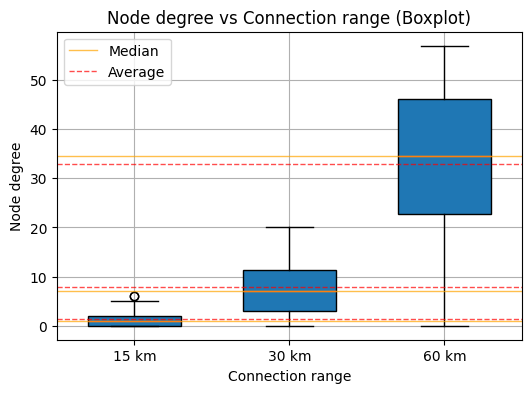

In [11]:
# Parameters
t = 500 #snapshot to vary 
range_values = [15000, 30000, 60000]  # meters


# Boxplots of degree for different connection ranges
degree_lists = []

for r in range_values:
    swarm, G = create_swarm_snapshot(dft, t, connection_range=r)
    degrees = [deg for _, deg in G.degree()]
    degree_lists.append(degrees)

plt.figure(figsize=(6,4))
plt.boxplot(degree_lists, positions=[1, 2, 3], widths=0.6, tick_labels=[f"{r//1000} km" for r in range_values],  patch_artist=True)


for i, degs in enumerate(degree_lists):
    plt.axhline(np.median(degs), color='orange', linestyle='-', linewidth=1, alpha=0.7, label='Median' if i == 0 else "")
    plt.axhline(np.mean(degs), color='red', linestyle='--', linewidth=1, alpha=0.7, label='Average' if i == 0 else "")

plt.legend()
plt.xlabel("Connection range")
plt.ylabel("Node degree")
plt.title("Node degree vs Connection range (Boxplot)")
plt.grid(True)
plt.show()


### 2. **Extended Neighborhood** (*k*-Vicinity)
- Measures how many nodes are within *k* hops (not just direct neighbors).
- Helps understand the reachability and depth of the network.
- Useful for routing and clustering evaluations.


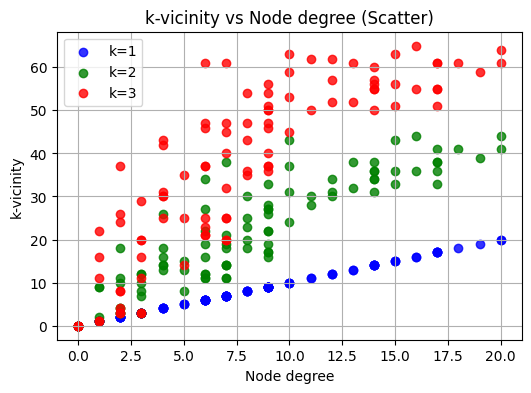

In [12]:
swarm, G = create_swarm_snapshot(dft, t, connection_range=30000)
degrees = dict(G.degree())
colors = ['blue', 'green', 'red']
k_values = [1, 2, 3]

plt.figure(figsize=(6,4))
for i, k in enumerate(k_values):
    kv_dict = k_vicinity_distribution(G, k=k)
    plt.scatter(
        [degrees[n] for n in kv_dict],
        list(kv_dict.values()),
        label=f"k={k}", color=colors[i], alpha=0.8
    )

plt.xlabel("Node degree")
plt.ylabel("k-vicinity")
plt.title("k-vicinity vs Node degree (Scatter)")
plt.legend()
plt.grid(True)
plt.show()

### Questions: Connectivity and Neighborhood Heterogeneity

Use degree distribution and *k*-vicinity plots to reflect on the swarms structure.

- Are all nodes in the swarm equally connected?
- Do some nodes have significantly more neighbors than others?
- Can you identify **heterogeneous connectivity** — i.e., the presence of both weakly and highly connected nodes?

- How does increasing the communication range affect this heterogeneity?
- Does the swarm become more uniformly connected, or do differences between nodes persist?

- In terms of extended neighborhood (*k*-vicinity):
  - What does it reveal about the global structure of the swarm?
  - Are some nodes reachable only through many hops?

> Conclude whether the swarm behaves as a homogeneous network or shows signs of topological imbalance.



## Swarm Availability: Contact Time Analysis

In this section, we analyze how often pairs of satellites are in direct contact throughout the simulation, using the **Contact Time (CT)** metric.

### What is Contact Time?

For each node pair `(u, v)`, we compute the **percentage of time steps** during which the two nodes are **directly connected** in the graph. (the ICT is calculated in  `metrics.py `)

This gives an estimate of how frequently links are available in the dynamic network.

### Interpretation:

- **0% CT**: the nodes were never connected during the simulation
- **100% CT**: the link was active at every snapshot
- Intermediate values indicate **intermittent contact**

We visualize:
- A **histogram** of the CT distribution across all node pairs
- A **CDF (Cumulative Distribution Function)** showing the proportion of links with availability below a given threshold

> This analysis helps us understand the overall **temporal availability** of communication links in the swarm.


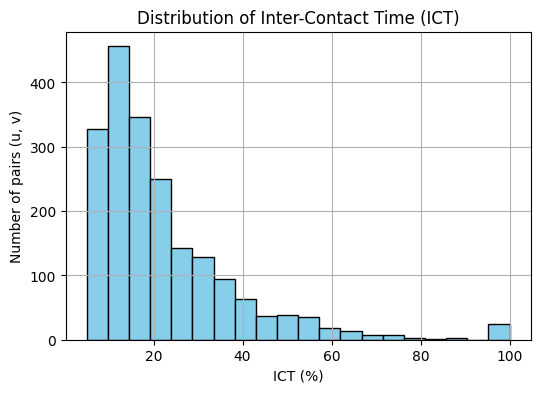

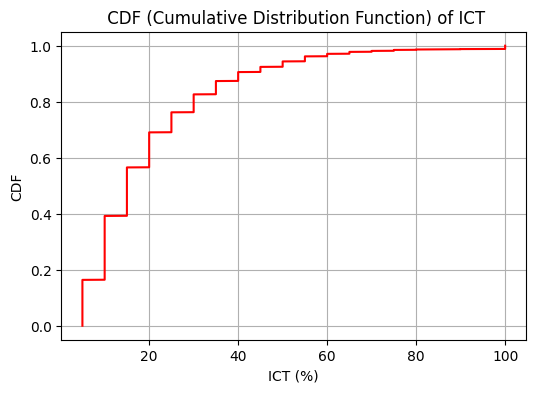

In [13]:
# Generate a series of graphs Gt
time_range = range(0, 2000, 100)  # snapshots every 100 snapshots (1000 s)
graph_series = []

for t in time_range:
    swarm, G = create_swarm_snapshot(dft, t, connection_range=30000)
    graph_series.append(G)

# Compute ICT (Inter-Contact Time)
ict_dict = inter_contact_time(graph_series)
ict_values = list(ict_dict.values())

# Histogram of ICT distribution
plt.figure(figsize=(6,4))
plt.hist(ict_values, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Inter-Contact Time (ICT)")
plt.xlabel("ICT (%)")
plt.ylabel("Number of pairs (u, v)")
plt.grid(True)
plt.show()

#  CDF (Cumulative Distribution Function) of ICT
plt.figure(figsize=(6,4))
sorted_ict = sorted(ict_values)
cdf = np.arange(len(sorted_ict)) / len(sorted_ict)
plt.plot(sorted_ict, cdf, color='red')
plt.title(" CDF (Cumulative Distribution Function) of ICT")
plt.xlabel("ICT (%)")
plt.ylabel("CDF")
plt.grid(True)

###  Visualizing Contact Time in 3D with Color Mapping

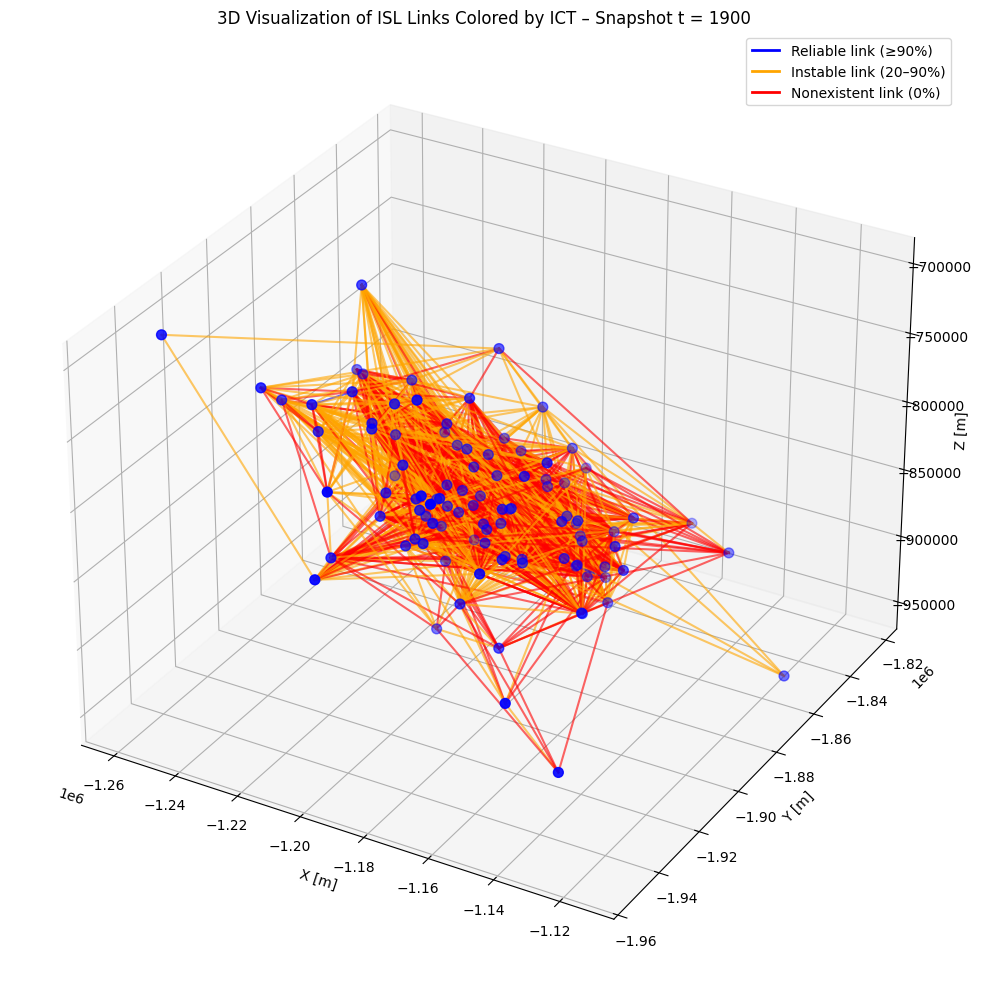

In [14]:

# Retrieve the positions of the satellites at the last snapshot
t_last = time_range[-1]
swarm, _ = create_swarm_snapshot(dft, t_last, connection_range=30000)
pos3d = {node.id: (node.x, node.y, node.z) for node in swarm.nodes}

# Create a graph with the observed edges
G_ict = nx.Graph()
for (u, v), ict in ict_dict.items():
    G_ict.add_edge(u, v)

# Prepare the 3D figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the nodes
x = [pos3d[n][0] for n in G_ict.nodes()]
y = [pos3d[n][1] for n in G_ict.nodes()]
z = [pos3d[n][2] for n in G_ict.nodes()]
ax.scatter(x, y, z, c='blue', s=50)

# plot edges with colors based on ICT 
for (u, v) in G_ict.edges():
    ict = ict_dict.get((u, v), 0)
    x_vals = [pos3d[u][0], pos3d[v][0]]
    y_vals = [pos3d[u][1], pos3d[v][1]]
    z_vals = [pos3d[u][2], pos3d[v][2]]

    if ict == 0:
        color = 'red'
    elif ict >= 90:
        color = 'blue'
    else:
        color = 'orange'

    ax.plot(x_vals, y_vals, z_vals, c=color, alpha=0.6)

# Legend and Title
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Reliable link (≥90%)'),
    Line2D([0], [0], color='orange', lw=2, label='Instable link (20–90%)'),
    Line2D([0], [0], color='red', lw=2, label='Nonexistent link (0%)'),
]
ax.legend(handles=legend_elements)
ax.set_title(f"3D Visualization of ISL Links Colored by ICT – Snapshot t = {t_last}")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
plt.tight_layout()
plt.show()


#  Resilience Management

Improving the resilience of the swarm while minimizing congestion on inter-satellite links (ISLs).

---

##  Division and Clustering Algorithms
The implementation of algorithms is given in  `swarm_sim.py `
### 1. Fair Load Distribution in the Network

**Initialization of Parameters**
To ensure consistency, the simulations use the following fixed parameters (except the number of nodes (here 100)):

<p align="center">
  <img src="table1.png" alt="Simulation Parameters Table" width="600"/>
</p>

<div align="center">
  <i>Source: Evelyne Akopyan, <br>
  <b>Fiabilité de l’architecture réseau des systèmes spatiaux distribués sur essaims de nanosatellites</b>, Université de Toulouse, 2024. [NNT: 2024TLSEP102], HAL: <a href="https://tel.archives-ouvertes.fr/tel-04796136">tel-04796136</a></i>
</div>

In [15]:
X_VALUES = [2, 5, 10, 15, 20, 30, 40, 50]  # number of groups
ITER = 30
TIMESTEPS = range(0, 1800, 100)  # 0s to 5h by the step of 100 

algos = ["RND", "MIRW", "FFD", "KMeans"]
connection_range = 30000
results = []



In [14]:
for x in X_VALUES:  # n_groups
    print(f"\n==== Étude pour x = {x} groupes ====")
    
    for iteration in range(ITER):
        seed = iteration
        random.seed(seed)
        np.random.seed(seed)

        for t in tqdm(TIMESTEPS, desc=f"t (x={x}, iter={iteration})"):

            # 1. Construct the dynamic graph Gt
            swarm, Gt = create_swarm_snapshot(dft, t, connection_range)
           
            # 2. Compute refernce metrics on Gt
            ref_force = avg_strength(Gt)
            ref_clust = average_clustering_coeff(Gt)
            ref_size = Gt.number_of_nodes() / x  # n / x
         

            for algo in algos:
                swarm.reset_groups()
                # 3. Apply division algorithm
                if algo == "RND":
                    groupes = swarm.RND(n=x)
                elif algo == "MIRW":
                    groupes = swarm.MIRW(n=x)
                elif algo == "FFD":
                    groupes = swarm.FFD(n=x)
                else:
                    groupes = swarm.kMeans(k=x)
              

                # 4. Compute metrics for each group
                forces, clusts, sizes = [], [], []
                for sub_swarm in groupes.values():
                    Gg = sub_swarm.swarm_to_nxgraph()
                    forces.append(avg_strength(Gg))
                    clusts.append(average_clustering_coeff(Gg))
                    sizes.append(len(Gg.nodes))
               

               
                group_dict = {}
                for group_id, sub_swarm in groupes.items():
                    for n in sub_swarm.nodes:
                        group_dict[n.id] = group_id
                nombre_flux= flow_number(Gt, group_dict)

                # 5.Campare via RMSE
                def rmse(Y, y0): return np.sqrt(np.mean([(y - y0)**2 for y in Y]))
                
                rmse_force = rmse(forces, ref_force)
                rmse_clust = rmse(clusts, ref_clust)
                rmse_size = rmse(sizes, ref_size)

                # 6. Store the results
                results.append({
                    "x": x,
                    "iter": iteration,
                    "t": t,
                    "algo": algo,
                    "rmse_force": rmse_force,
                    "rmse_clustering": rmse_clust,
                    "rmse_size": rmse_size,
                     # reference values for the rmse function
                    "ref_force": ref_force,
                    "ref_clustering": ref_clust,
                    "ref_size": ref_size,
                    "flux_ref": nombre_flux["flux_ref"],
                    "flux_div": nombre_flux["flux_div"]
                    
                })
               




==== Étude pour x = 2 groupes ====


t (x=2, iter=29): 100%|████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.60it/s]



==== Étude pour x = 5 groupes ====


t (x=5, iter=29): 100%|████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.06it/s]



==== Étude pour x = 10 groupes ====


t (x=10, iter=29): 100%|███████████████████████████████████████████████████████████████| 18/18 [00:03<00:00,  4.62it/s]



==== Étude pour x = 15 groupes ====


t (x=15, iter=29): 100%|███████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.62it/s]



==== Étude pour x = 20 groupes ====


t (x=20, iter=29): 100%|███████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.07it/s]



==== Étude pour x = 30 groupes ====


t (x=30, iter=29): 100%|███████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.28it/s]



==== Étude pour x = 40 groupes ====


t (x=40, iter=29): 100%|███████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.82it/s]



==== Étude pour x = 50 groupes ====


t (x=50, iter=29): 100%|███████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.49it/s]


In [15]:
# ========== Download as CSV ==========
df = pd.DataFrame(results)
df.to_csv("rmse_global_results.csv", index=False)

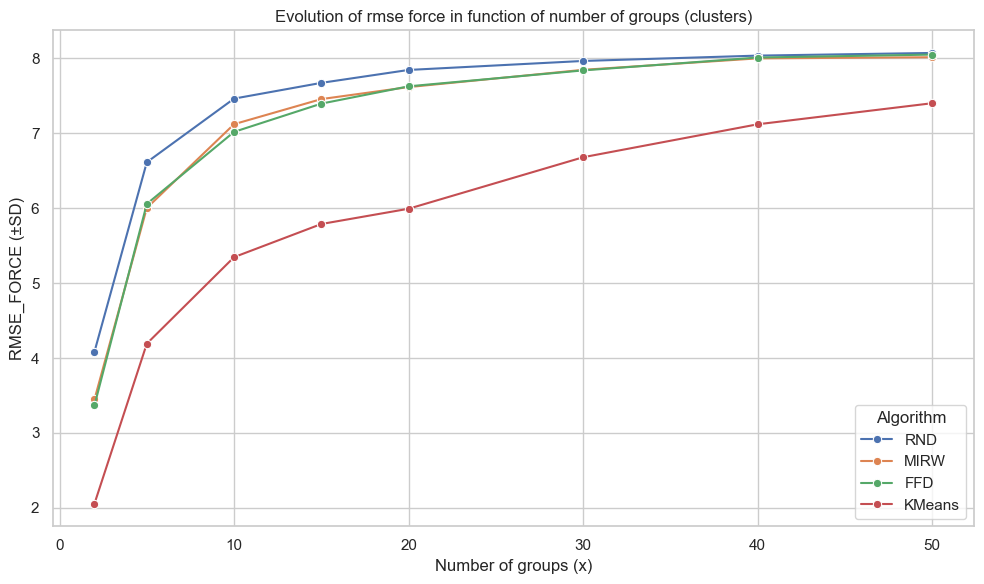

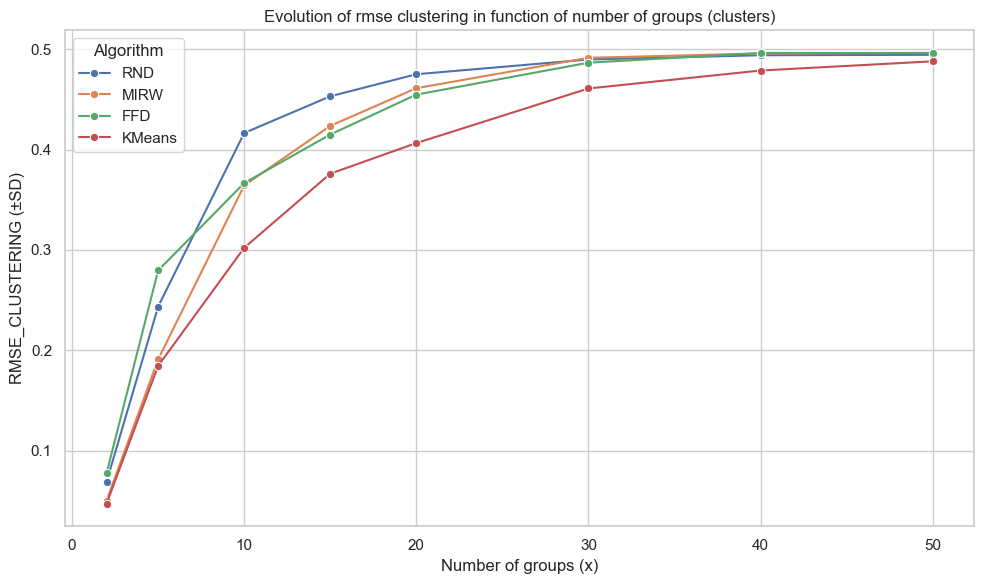

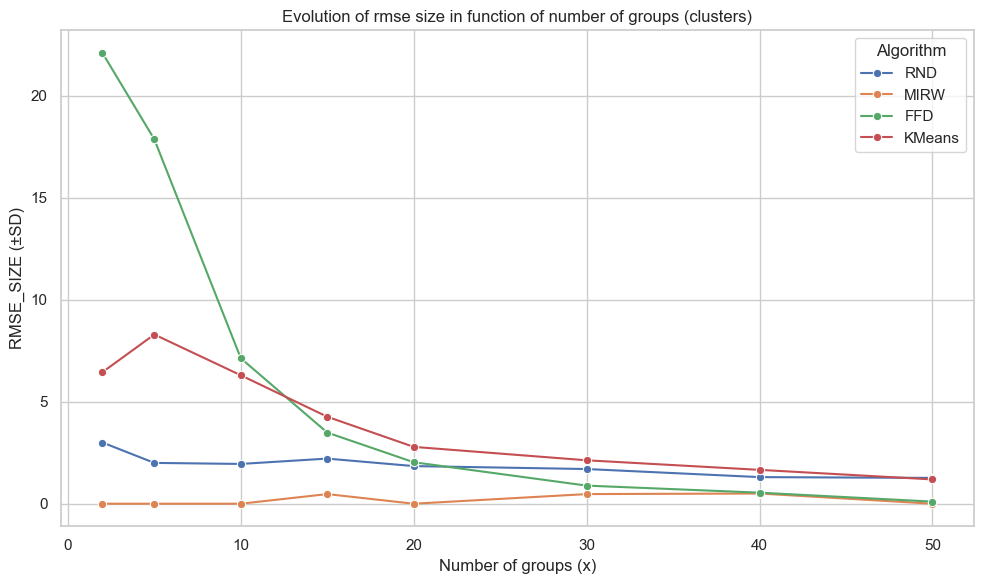

In [28]:
metrics = ["rmse_force", "rmse_clustering", "rmse_size"]
df_rmse = pd.read_csv("rmse_global_results.csv")
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_rmse, x="x", y=metric, hue="algo", errorbar=None, marker="o")
    plt.title(f"Evolution of {metric.replace('_', ' ')} in function of number of groups (clusters)")
    plt.xlabel("Number of groups (x)")
    plt.ylabel(f"{metric.upper()} (±SD)")
    plt.grid(True)
    plt.legend(title="Algorithm")
    plt.tight_layout()
    plt.show()


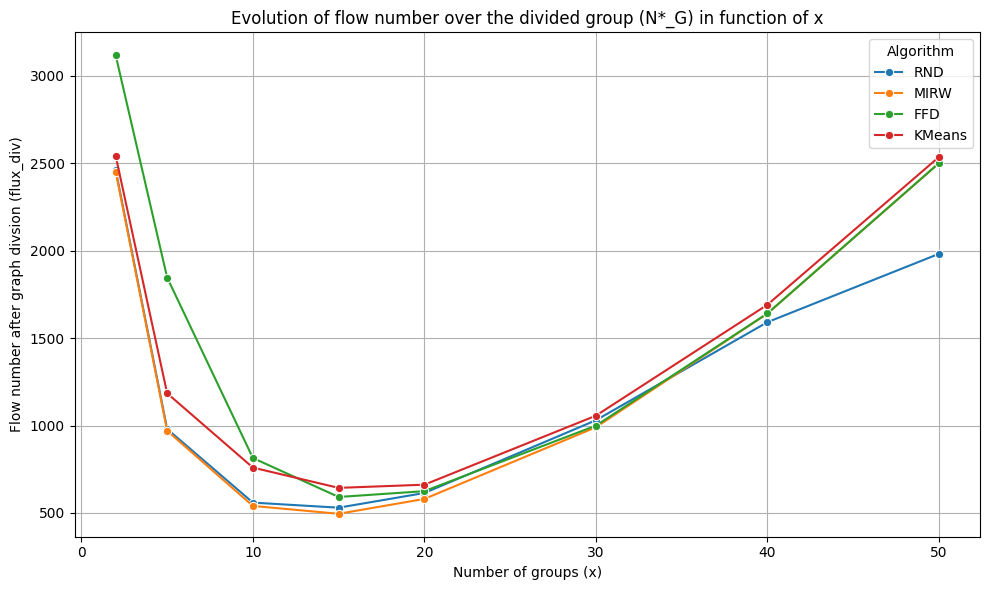

In [18]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_rmse, x="x", y="flux_div", hue="algo", errorbar=None, marker="o")
plt.title("Evolution of flow number over the divided group (N*_G) in function of x")
plt.xlabel("Number of groups (x)")
plt.ylabel("Flow number after graph divsion (flux_div)")
plt.grid(True)
plt.legend(title="Algorithm")
plt.tight_layout()
plt.savefig("plot_flux_div.png")
plt.show()


## 2. Distributed System Reliability

Improving the reliability of a distributed satellite network under dynamic conditions.

---

### **Parameter Initialization**

We define the main simulation parameters:

- `X_VALUES`: number of clusters to generate
- `ITER`: number of repetitions (to average out randomness)
- `TIMESTEPS`: time steps across the simulation (every 100 seconds up to 5 hours)
- `algos`: the division algorithms being tested

---
To ensure consistency, the simulations use the following fixed parameters (except the number of nodes (here 100)):

<p align="center">
  <img src="table2.png" alt="Simulation Parameters Table" width="600"/>
</p>

<div align="center">
  <i>Source: Evelyne Akopyan, <br>
  <b>Fiabilité de l’architecture réseau des systèmes spatiaux distribués sur essaims de nanosatellites</b>, Université de Toulouse, 2024. [NNT: 2024TLSEP102], HAL: <a href="https://tel.archives-ouvertes.fr/tel-04796136">tel-04796136</a></i>
</div>


In [19]:
X_VALUES = 10  # number of groups
ITER = 30
TIMESTEPS = range(0, 1800, 100)  # 0 to 5h (time of revolution = 1800 ech)

algos = ["RND", "MIRW", "FFD", "KMeans"]
connection_range = 30000
results_fiabilite = []


### 2.1 Robustness Metrics 
- **Flow Robustness**: connectivity between node pairs
- **Routing Cost**: total path length for routing messages
- **Network Efficiency**: communication efficiency across the graph
In this part, we compute and compare several robustness-related metrics over time.

We evaluate the performance of the system both:
- without clustering (flat graph), and
- with each division method (`RND`, `MIRW`, `FFD`, `KMeans`)

Each configuration is repeated several times with random seeds, and metrics are averaged across iterations.

In [16]:

# Initialize a list to store the results
results = []

# Simulation
for iteration in range(ITER):
    np.random.seed(iteration)
    group_dicts = {}

    for t in tqdm(TIMESTEPS, desc=f"Iter {iteration}"):
        swarm, Gt = create_swarm_snapshot(dft, t, connection_range)

        # --- Reference: nondivided group ---
        results.append({
            "iteration": iteration,
            "t": t,
            "algo": "none",
            "divided": False,
            "flow_robustness": flow_robustness(Gt),
            "routing_cost": routing_cost(Gt),
            "network_efficiency": network_efficiency(Gt)
        })

        # --- Initialization of groups/ clusters ---
        
            for algo in ALGOS:
                swarm.reset_groups()
                if algo == "RND":
                    groupes = swarm.RND(n=X)
                elif algo == "MIRW":
                    groupes = swarm.MIRW(n=X)
                elif algo == "FFD":
                    groupes = swarm.FFD(n=X)
                else:
                    groupes = swarm.kMeans(k=X)

                group_dict = {
                    node.id: group_id
                    for group_id, sub in groupes.items()
                    for node in sub.nodes
                }
                group_dicts[algo] = group_dict

        # --- Divided Graph metrics ---
        for algo in ALGOS:
            group_dict = group_dicts[algo]
            results.append({
                "iteration": iteration,
                "t": t,
                "algo": algo,
                "divided": True,
                "flow_robustness": flow_robustness(Gt, divided=True, group_dict=group_dict),
                "routing_cost": routing_cost(Gt, divided=True, group_dict=group_dict),
                "network_efficiency": network_efficiency(Gt, divided=True, group_dict=group_dict)
            })

# Restore
df = pd.DataFrame(results)
df.to_csv("reliability_robustnessMetrics.csv", index=False)


Iter 29: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.28it/s]


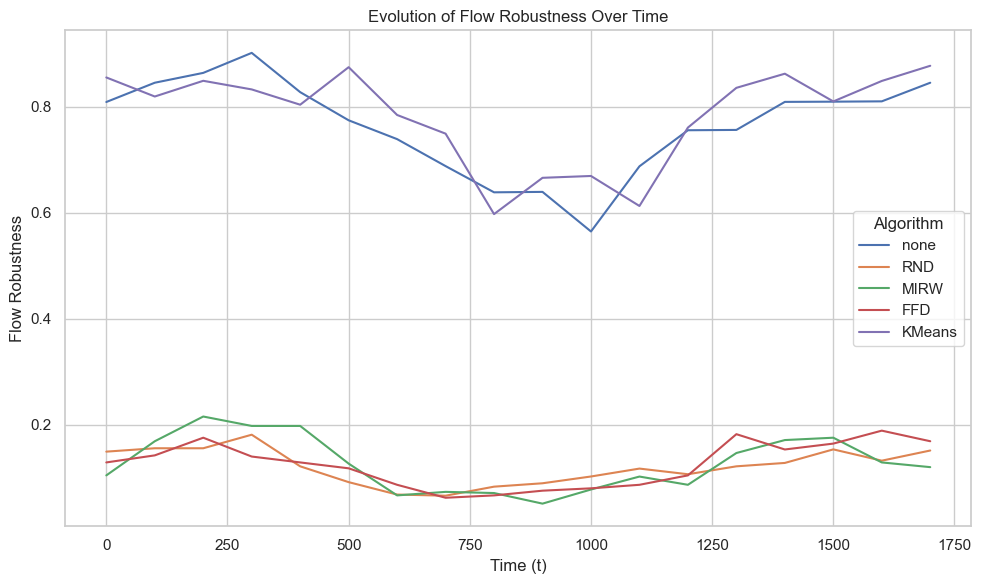

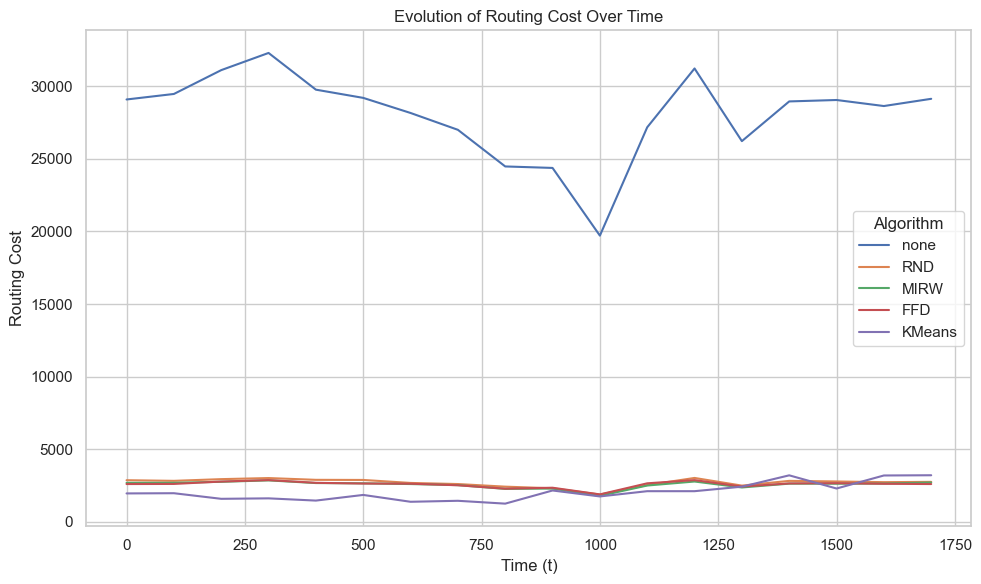

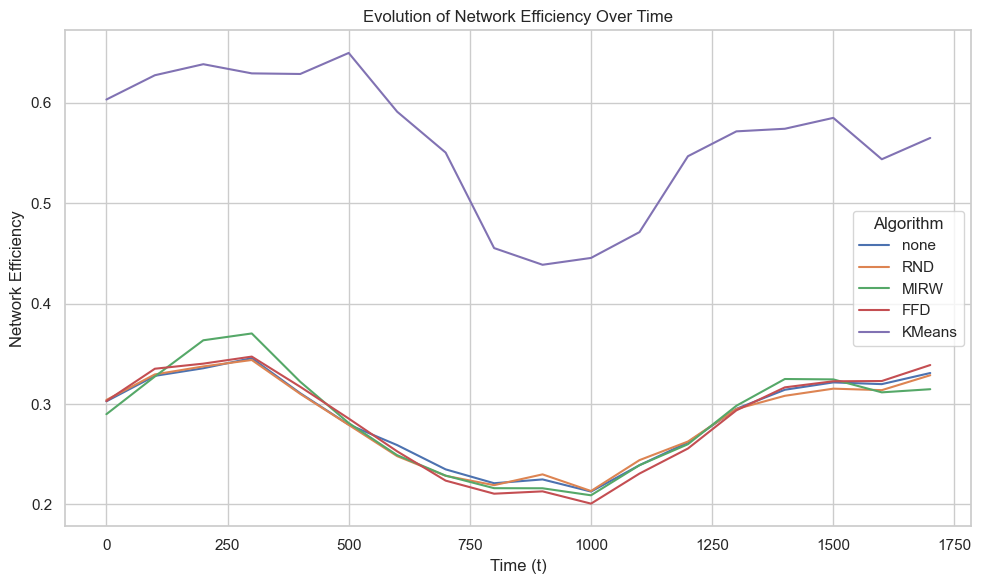

In [29]:
# Load the data
df = pd.read_csv("reliability_robustnessMetrics.csv")

# Optional: configure seaborn style
sns.set(style="whitegrid")

# Metrics to plot
metrics = ["flow_robustness", "routing_cost", "network_efficiency"]

for metric in metrics:
    plt.figure(figsize=(10, 6))
    
    # Plot each algorithm including "none" (reference case)
    for algo in df["algo"].unique():
        df_algo = df[df["algo"] == algo]
        avg = df_algo.groupby("t")[metric].mean().reset_index()
        plt.plot(avg["t"], avg[metric], label=f"{algo}")
    plt.title(f"Evolution of {metric.replace('_', ' ').title()} Over Time")
    plt.xlabel("Time (t)")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend(title="Algorithm")
    plt.tight_layout()
    plt.show()

### 2.2 Resilience Metrics

In this part of the TP, we analyze the **resilience** of the nanosatellite swarm network using a set of structural metrics. These metrics help us assess how robust the network remains under different routing and connectivity conditions.

We will evaluate the following:

- **Path Redundancy**: Number of alternative shortest paths between nodes. This metric reflects the network’s ability to reroute data in case of link/node failure.
- **Path Disparity**: Structural differences between shortest paths. High disparity indicates more diverse routing options.
- **Critical Nodes**: Proportion of nodes with high centrality. These nodes are essential for maintaining network connectivity.

---
 **Instructions**:

Due to the high execution time of each simulation, **only one metric is computed per run** and the results are saved in CSV files.  
> For this TP, the simulations have already been precomputed with these parameters. You can load the CSV files to analyze the results and avoid long runtimes.
> to test different parameters you need to uncomment the next cell and execute with each metric per run

**Your tasks**:
1. Choose one of the metrics and run the simulation (if working with differenet parameters than above).
2. Load the corresponding results file.
3. Analyze the impact of parameters such as group size, connection range...
4. Interpret how each metric reflects the network’s resilience properties.

>  *The cell for re-running simulations is commented out to prevent unnecessary execution.*


In [ ]:
"""# Choix de la métrique à calculer :
METRIC_NAME = "path_disparity" 

# Paramètres réduits pour test
ITER = 30
TIMESTEPS =  range(0, 1801, 100)
ALGOS = ["RND", "MIRW", "FFD", "KMeans"]
X = 10
EPSILON = 0.05

# Fonction de dispatch
def compute_metric(name, G, divided=False, group_dict=None):
    if name == "path_redundancy":
        return path_redundancy(G, divided=divided, group_dict=group_dict)
    elif name == "path_disparity":
        return path_disparity(G, divided=divided, group_dict=group_dict)
    elif name == "critical_nodes":
        return critical_nodes(G,epsilon=EPSILON, divided=divided, group_dict=group_dict)

# Simulation
results = []

for iteration in range(ITER):
    np.random.seed(iteration)
    group_dicts = {}

    for t in tqdm(TIMESTEPS, desc=f"[{METRIC_NAME}] Iter {iteration}"):
        swarm, Gt = create_swarm_snapshot(dft, t, connection_range)

        # Graphe non divisé
        results.append({
            "iteration": iteration,
            "t": t,
            "algo": "none",
            "divided": False,
            METRIC_NAME: compute_metric(METRIC_NAME, Gt)
        })

        # Initialisation des groupes à t = 0
        if t == 0:
            for algo in ALGOS:
                swarm.reset_groups()
                groupes = (
                    swarm.RND(n=X) if algo == "RND" else
                    swarm.MIRW(n=X) if algo == "MIRW" else
                    swarm.FFD(n=X) if algo == "FFD" else
                    swarm.kMeans(k=X)
                )
                group_dicts[algo] = {
                    node.id: group_id
                    for group_id, sub in groupes.items()
                    for node in sub.nodes
                }

        # Graphe divisé
        for algo in ALGOS:
            group_dict = group_dicts[algo]
            results.append({
                "iteration": iteration,
                "t": t,
                "algo": algo,
                "divided": True,
                METRIC_NAME: compute_metric(METRIC_NAME, Gt, divided=True, group_dict=group_dict)
            })

# Sauvegarde
df = pd.DataFrame(results)
df.to_csv(f"resilience_{METRIC_NAME}.csv", index=False)
print(f"Résultats enregistrés : resilience_{METRIC_NAME}.csv")"""


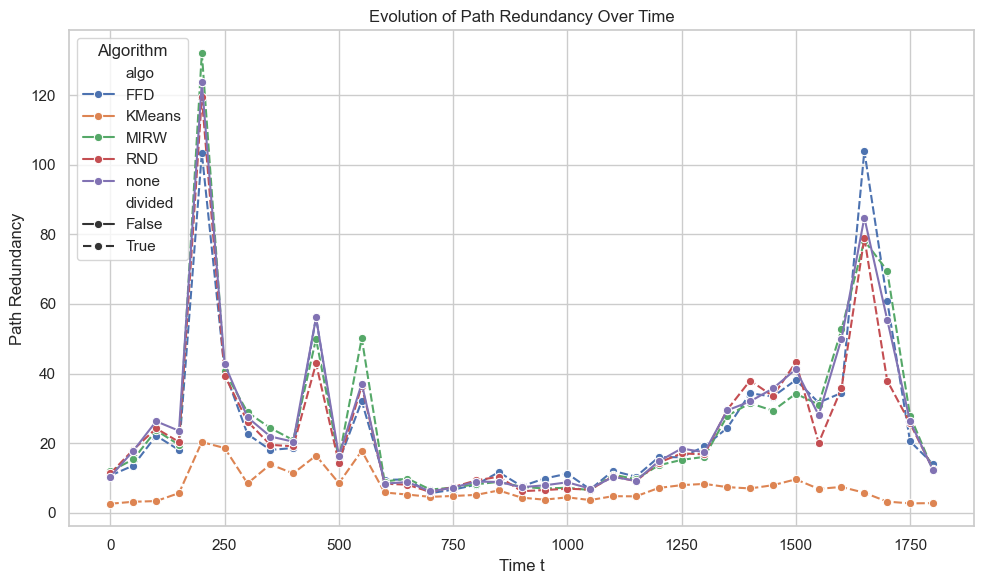

In [30]:
# Charger le fichier exporté
df = pd.read_csv("resilience_path_redundancy.csv")
# Compute mean and std over iterations
df_avg = df.groupby(["t", "algo", "divided"])["path_redundancy"].mean().reset_index()

# Plot the average
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_avg, x="t", y="path_redundancy", hue="algo", style="divided", marker="o")
plt.title("Evolution of Path Redundancy Over Time")
plt.xlabel("Time t")
plt.ylabel("Path Redundancy")
plt.grid(True)
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()

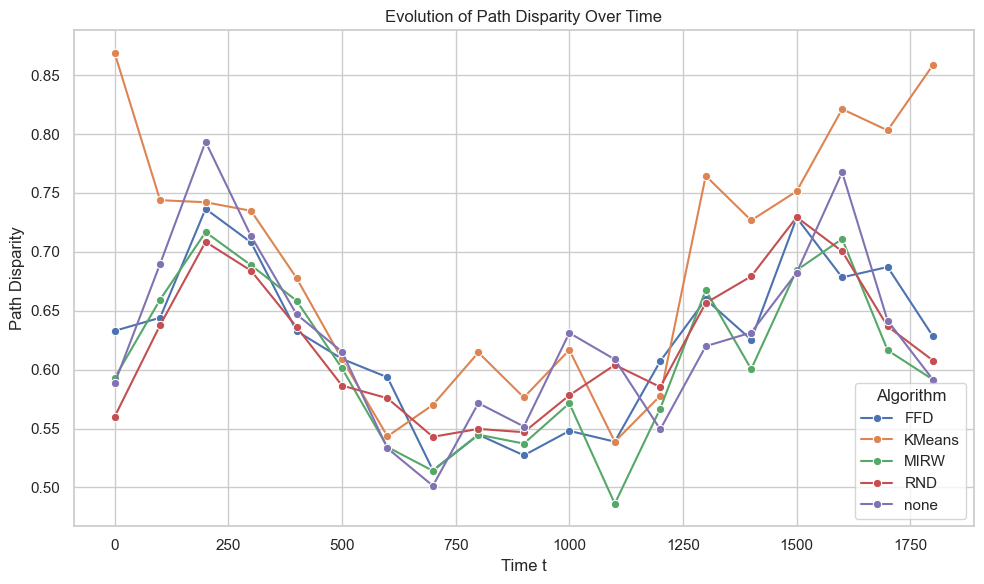

In [31]:
#Load the file
df = pd.read_csv("resilience_path_disparity.csv")

# Compute mean and std over iterations
df_avg = df.groupby(["t", "algo"])["path_disparity"].mean().reset_index()

# Plot the average line
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_avg, x="t", y="path_disparity", hue="algo", marker="o")
plt.title("Evolution of Path Disparity Over Time")
plt.xlabel("Time t")
plt.ylabel("Path Disparity")
plt.grid(True)
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()

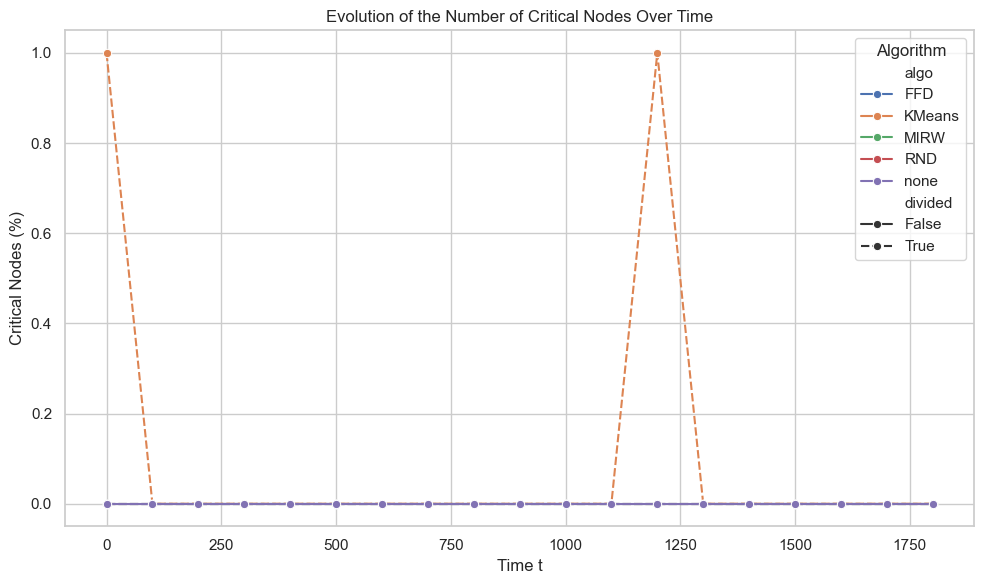

In [32]:
# Load the file 
df = pd.read_csv("resilience_critical_nodes.csv")

# Average over iterations
df_avg = df.groupby(["t", "algo", "divided"])["critical_nodes"].mean().reset_index()

# Plot the average
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_avg, x="t", y="critical_nodes", hue="algo", style="divided", marker="o")
plt.title("Evolution of the Number of Critical Nodes Over Time")
plt.xlabel("Time t")
plt.ylabel("Critical Nodes (%)")
plt.grid(True)
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()


#  Failure Simulation and Resilience Analysis on the Swarm 



In this section, you will evaluate the impact of node failures on the resilience and robustness of the nanosatellite swarm network. 
Failures will be simulated under different conditions — using different graph partioning and clustering algorithms — and analyzed using key graph-based metrics that we saw in the previous part.

### Objectives
- Assess how node failures affect the network.
- Compare the network's resilience with and without division.
- Analyze the role of division algorithms in failure recovery.
- Examine how network density influences failure impact.

### What to Do

1. **Choose a time step** `t` (e.g., 0, 100, 1800).  
   These correspond to different network topologies — some sparse, some dense.

   (you'll need to analyze graph density over time)

3. **Simulate node failures** using two modes:
   - **Random**: select nodes uniformly at random.
   - **Targeted (critical)**: remove the most critical nodes (e.g., those with highest betweenness centrality).

4. **Vary the number of failed nodes** (`n_fail`) to study:
   - Small failures (e.g., 1 node)
   - Moderate failures (e.g., 5 nodes)
   - Large failures (e.g., 10+ nodes)

5. For each configuration:
   - Evaluate the system **before and after failure**.
   - Compare results for:
     - No divsion (refernce graph)
     - Division and Clustering via: `RND`, `MIRW`, `FFD`, and `KMeans`

6. **Analyze the results**:
   - Which algorithm preserves robustness best?
   - Are critical-node failures more damaging than random ones?
   - Is the network more resilient when dense or sparse?

### Metrics to Observe

- **Flow Robustness**: connectivity between node pairs
- **Routing Cost**: total path length for routing messages
- **Network Efficiency**: communication efficiency across the graph
- **Path Redundancy**: number of shortest path alternatives
- **Path Disparity**: structural difference between paths
- **Critical Nodes**: percentage of highly central nodes

### Use the plots provided to interpret how each algorithm and failure model influences the behavior of the network.


In [34]:
def simulate_failure(G, group_dict=None, n_fail=5, mode="random", divided=False, epsilon=0.05):
    """
    Simulate node failure in the graph :
    - mode 'random' : randomly select the nodes to fail
    - mode 'targeted' : remove the nodes with high criticality

    Args :
        G : graph (nx.Graph)
        group_dict : {node_id: group_id} if divided=True
        n_fail : nb of nodes to remove
        mode : 'random' or 'targeted'
        divided : evaluate the criticality of intra-group if True
        epsilon : threshold (used in critical_nodes if needed)

    Returns :
        G_failed : graph after failure
        failed_nodes : list of removed nodes
    """
    all_nodes = list(G.nodes)

    if mode == "random":
        failed_nodes = list(np.random.choice(all_nodes, size=min(n_fail, len(all_nodes)), replace=False))

    elif mode == "targeted":
        crit_scores = node_criticality(G, divided=divided, group_dict=group_dict)
        sorted_nodes = sorted(crit_scores.items(), key=lambda x: x[1], reverse=True)
        failed_nodes = [n for n, _ in sorted_nodes[:min(n_fail, len(sorted_nodes))]]

    else:
        raise ValueError("invalid Mode : chose 'random' or 'targeted'.")

    G_failed = G.copy()
    G_failed.remove_nodes_from(failed_nodes)

    return G_failed, failed_nodes


In [32]:
def get_metrics(G, name, divided=False, group_dict=None):
    """
    Computes robustness and resilience metrics for a graph.

    Args:
        G (nx.Graph): Graph to be evaluated
        name (str): Identifier for the case (label for the DataFrame)
        divided (bool): True if evaluating within groups
        group_dict (dict): Dictionary {node_id: group_id}, required if divided=True

    Returns:
        dict: Case name along with metric values
    """
    return {
        "name": name,
        "flow_robustness": flow_robustness(G, divided=divided, group_dict=group_dict),
        "routing_cost": routing_cost(G, divided=divided, group_dict=group_dict),
        "network_efficiency": network_efficiency(G, divided=divided, group_dict=group_dict),
        "path_redundancy": path_redundancy(G, divided=divided, group_dict=group_dict),
        "path_disparity": path_disparity(G, divided=divided, group_dict=group_dict),
        "critical_nodes": critical_nodes(G, divided=divided, group_dict=group_dict)
    }


removed nodes : [np.int64(25), np.int64(39), np.int64(19), np.int64(78), np.int64(20)]


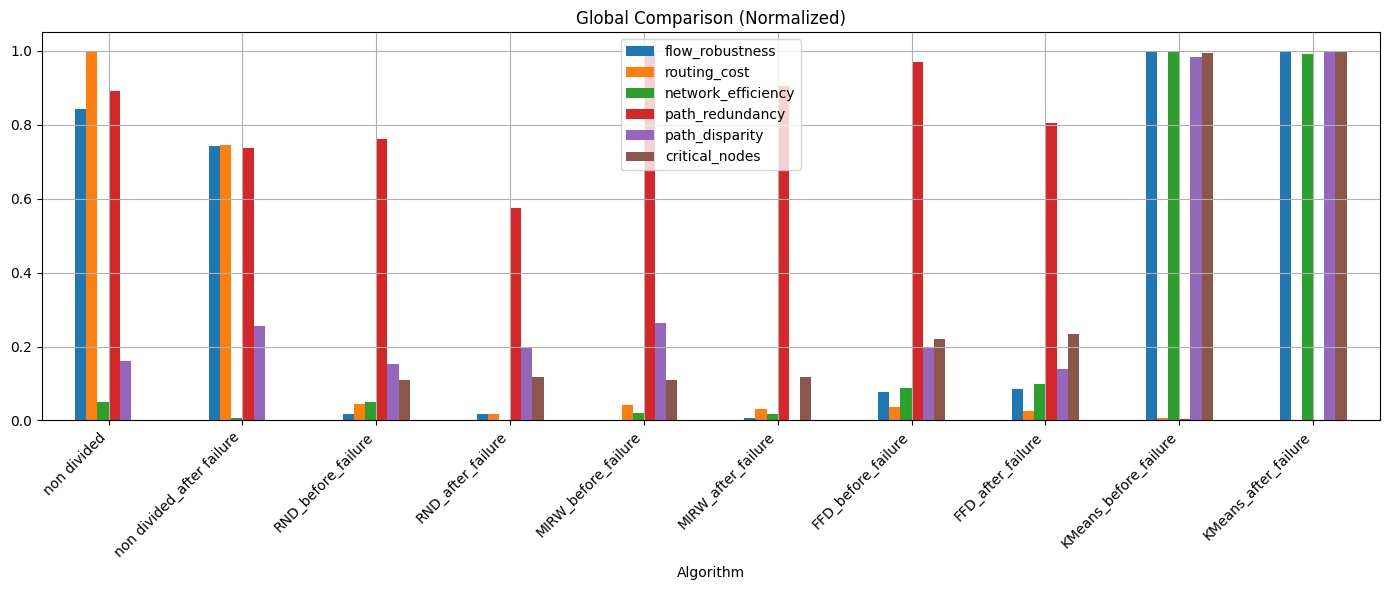

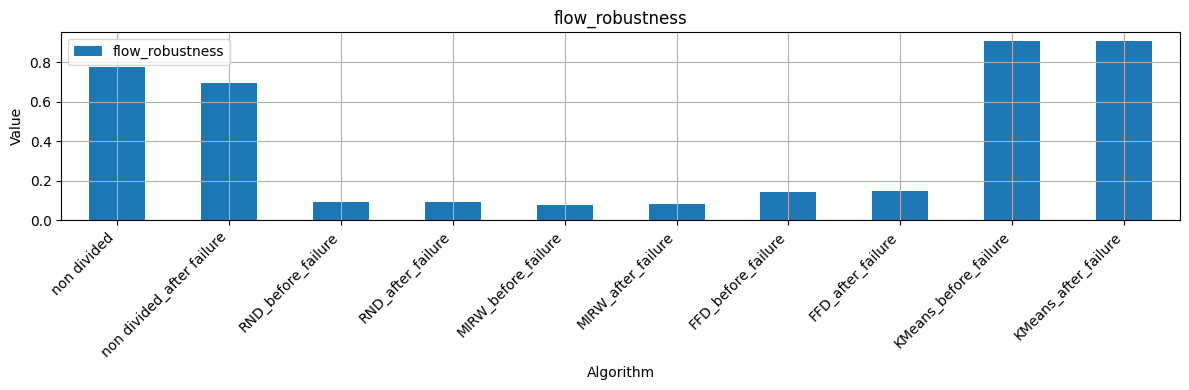

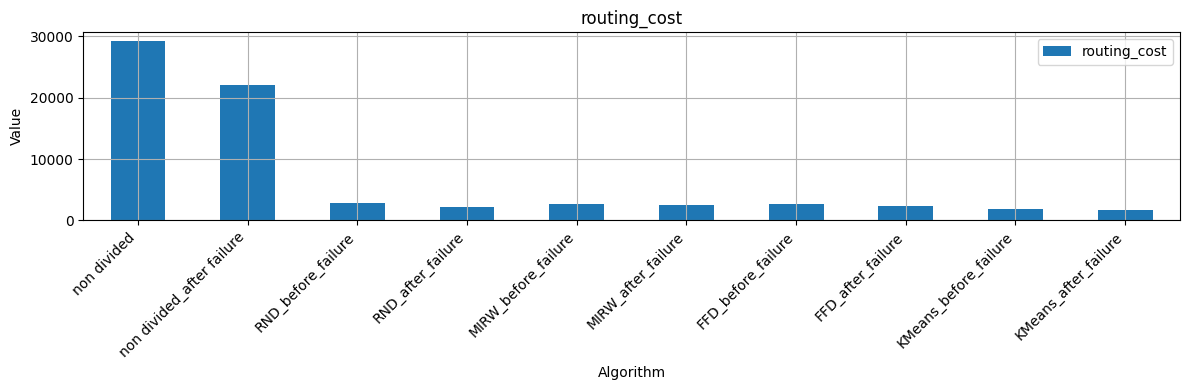

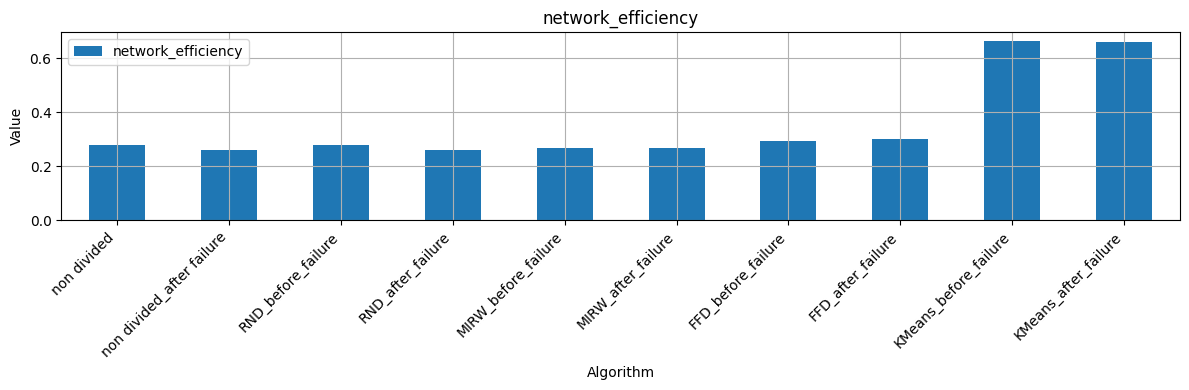

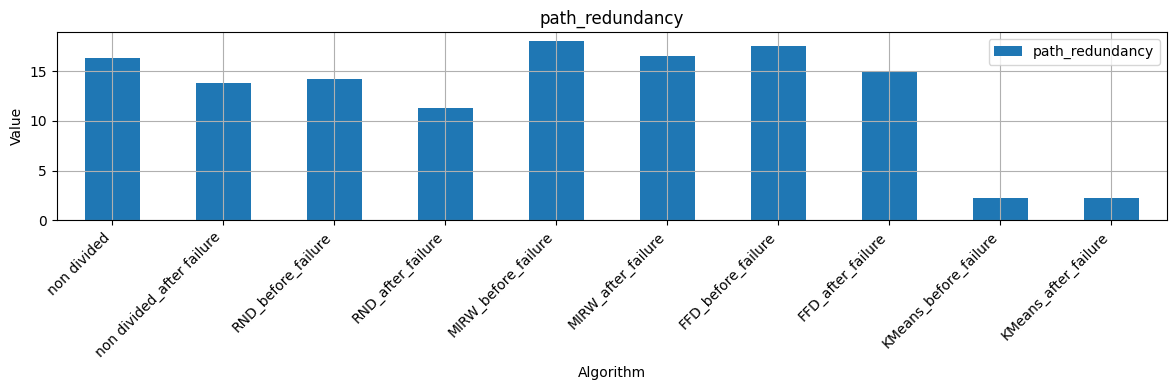

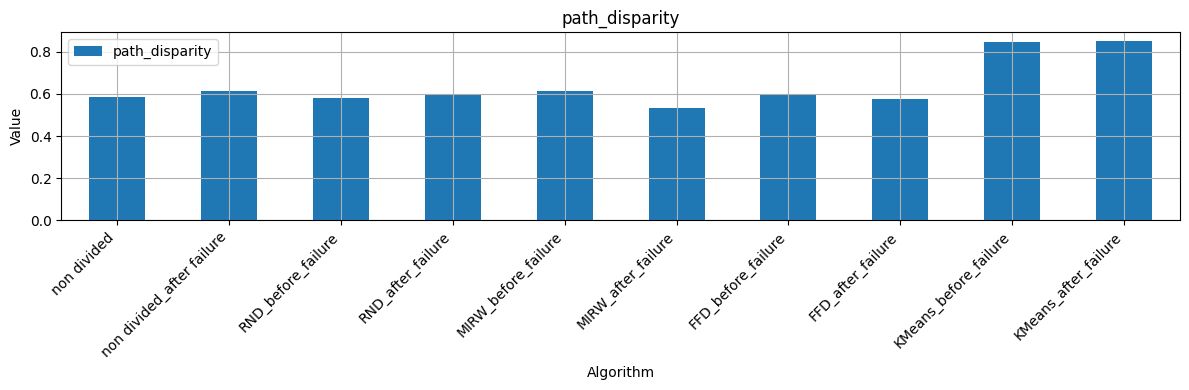

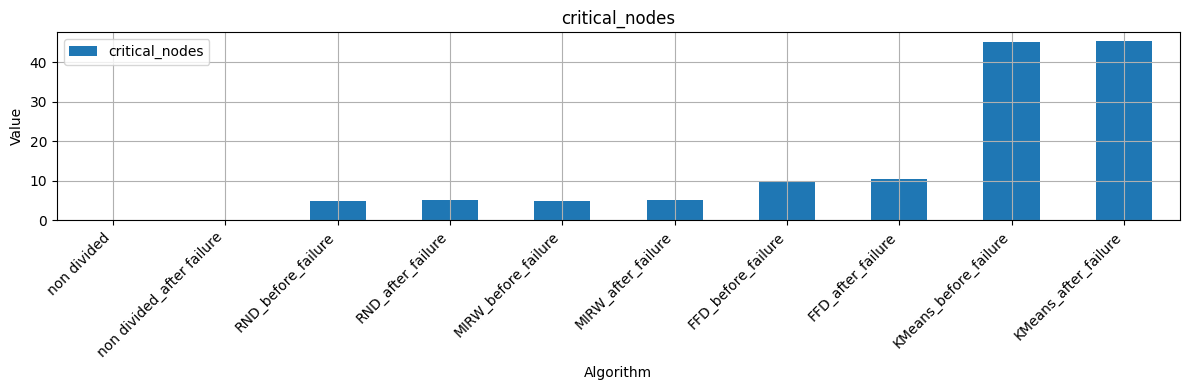

In [39]:
# === Script for simulating failures at a chosen snapshot ===

#######################################################################################
#############################    PARAMETERS    ########################################
#######################################################################################
t = 500  # snapshot (to vary corresponding to different network topology)
swarm, G_ref = create_swarm_snapshot(dft, t, connection_range)
n_fail = 5  # number of attacked or failed nodes(nanosatellites)
mode = "random"

results = []


#######################################################################################
#############################    SIMULATION    ########################################
#######################################################################################
# === 1. Reference (graph before division, no failure) ===
results.append(get_metrics(G_ref, "non divided", group_dict=None))

# === 2. Failure on the reference graph ===
G_failed_nodiv, failed_nodes = simulate_failure(G_ref, None, n_fail=n_fail, mode=mode, divided=False)
print("removed nodes :", failed_nodes)
results.append(get_metrics(G_failed_nodiv, "non divided_after failure", divided=False, group_dict=None))

# ===  Graph divison : Partitioning(RND,FFD,MIRW), Clustering(KMeans) ===
for algo in ["RND", "MIRW", "FFD", "KMeans"]:
    swarm.reset_groups()
    if algo == "RND":
        groupes = swarm.RND(n=10)
    elif algo == "MIRW":
        groupes = swarm.MIRW(n=10)
    elif algo == "FFD":
        groupes = swarm.FFD(n=10)
    else:
        groupes = swarm.kMeans(k=10)

    group_dict = {
        node.id: group_id
        for group_id, sub_swarm in groupes.items()
        for node in sub_swarm.nodes
    }

    # === 3. diveded graph, no failure metrics ===
    results.append(get_metrics(G_ref, f"{algo}_before_failure", divided=True, group_dict=group_dict))

    # === 4. diveded graph after failure metrics ===
    G_failed_div, _ = simulate_failure(G_ref, group_dict, n_fail=n_fail, mode=mode, divided=True)
    results.append(get_metrics(G_failed_div, f"{algo}_after_failure", divided=True, group_dict=group_dict))

# === Convertir en DataFrame pour analyse ===
df_eval = pd.DataFrame(results).set_index("name").T



#######################################################################################
#############################    VISUALIZATION    #####################################
#######################################################################################
# === VISUALISATION of Metrics ===

# === 1. Global Comparison (normalized) ===
df_norm = (df_eval - df_eval.min(axis=1).values[:, None]) / (df_eval.max(axis=1) - df_eval.min(axis=1)).values[:, None]
df_norm.T.plot(kind="bar", figsize=(14, 6), title="Global Comparison (Normalized)")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Algorithm")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Comparison by Metric ===
for metric in df_eval.index:
    df_eval.loc[[metric]].T.plot(kind="bar", title=metric, ylabel="Value", figsize=(12, 4))
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.xlabel("Algorithm")
    plt.show()


### Questions for Analysis

1. **Which failure mode (random vs. targeted) has the most severe effect on the network? Why?**
2. **Does the network recover better with a specific clustering algorithm? Which one and under what conditions?**
3. **How does the level of node centrality relate to failure impact?**
4. **What role does network density play in improving or weakening resilience?**
5. **Are any division algorithms more effective in sparse topologies than in dense ones?**
6. **Can you identify a trade-off between clustering overhead and failure robustness?**

# Network Density Exploration

Before analyzing failure scenarios, it's important to understand how the **structure of the network evolves over time**. In this section, you'll study the **graph density** at various time steps to identify:

- When the network is **sparse** (fewer connections between satellites)
- When the network is **dense** (highly connected topology)

### Why it matters
Network density can significantly influence:
- The network's vulnerability to failures
- The availability of alternate paths
- The performance of routing and clustering algorithms

---

### Task: Analyze Graph Density Over Time

1. **Compute the density** of the graph for a series of time steps using the formula:

  
   $$ 
   \text{Density} = \frac{2 \times |E|}{|V| \times (|V| - 1)} 
   $$


   Where:
   - \( |V| \) is the number of nodes (nano-satellites)
   - \( |E| \) is the number of edges (communication links)

2. **Plot the density** across time (e.g., every 100 seconds) to visualize how the topology evolves for the time of revolution 5h knowing that each time step in "Traces.csv" is 10s.

3. **Identify key time points**:
   - One with **high density** (many connections)
   - One with **low density** (sparse connections)

4. **Use these key time points** in the failure *simulation section* to compare how the network behaves under failures in different connectivity regimes.

---

### Hints

- You can use `networkx.density(graph)` if using NetworkX for graph representation.
- Save and annotate your plots to reference later in your analysis.

---

*After your analysis, reflect on how density trends might correlate with satellite movement, coverage areas, or network design choices.*


In [ ]:
# To do 
...